# FPN Object Detection Visualization

This notebook demonstrates the Feature Pyramid Network (FPN) bounding box detection mechanism. We'll load a trained model, perform inference on images, and visualize the detected objects with bounding boxes, class labels, and confidence scores.

## 1. Import Required Libraries

In [1]:
import sys
import os

# Add modernized_fpn directory to path to import modules
sys.path.insert(0, os.path.abspath('modernized_fpn'))

import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from model import Model
from backbone.base import Base as BackboneBase
from dataset.base import Base as DatasetBase
from config.eval_config import EvalConfig as Config

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
CUDA available: True


## 2. Load Trained Model

In [ ]:
# Configuration
CHECKPOINT_PATH = 'modernized_fpn/outputs/checkpoints-20251119144440-voc2007-resnet101-98a73035/model-80000.pth'
DATASET_NAME = 'voc2007'
BACKBONE_NAME = 'resnet101'

# VOC 2007 class names
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
    'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
print("Loading model...")
dataset = DatasetBase.from_name(DATASET_NAME)
backbone = BackboneBase.from_name(BACKBONE_NAME)(pretrained=False)
model = Model(
    backbone, 
    dataset.num_classes(), 
    pooling_mode=Config.POOLING_MODE,
    anchor_ratios=Config.ANCHOR_RATIOS, 
    anchor_scales=Config.ANCHOR_SCALES,
    rpn_pre_nms_top_n=Config.RPN_PRE_NMS_TOP_N, 
    rpn_post_nms_top_n=Config.RPN_POST_NMS_TOP_N
).to(device)

# Load checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print(f"Model loaded from step {checkpoint['step']}")
print(f"Number of classes: {len(VOC_CLASSES)}")

Using device: cuda
Loading model...


/tmp/.khin/ipykernel_3810505/2179243904.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)


Model loaded from step 80000
Number of classes: 21


## 3. Define Helper Functions for Visualization

In [5]:
def preprocess_image(image_path, min_side=800, max_side=1333):
    """Load and preprocess image for the model"""
    image = Image.open(image_path).convert('RGB')
    original_image = image.copy()
    
    # Resize image
    w, h = image.size
    scale = min(min_side / min(h, w), max_side / max(h, w))
    new_w, new_h = int(w * scale), int(h * scale)
    image = image.resize((new_w, new_h), Image.BILINEAR)
    
    # Convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).to(device)
    
    return image_tensor, original_image, scale


def run_inference(model, image_tensor, confidence_threshold=0.7):
    """Run model inference and return detections"""
    with torch.no_grad():
        forward_input = Model.ForwardInput.Eval(image_tensor)
        forward_output = model.eval().forward(forward_input)
    
    detection_bboxes = forward_output.detection_bboxes
    detection_classes = forward_output.detection_classes
    detection_probs = forward_output.detection_probs
    
    # Filter by confidence threshold
    mask = detection_probs >= confidence_threshold
    detection_bboxes = detection_bboxes[mask]
    detection_classes = detection_classes[mask]
    detection_probs = detection_probs[mask]
    
    return detection_bboxes, detection_classes, detection_probs


def visualize_detections(image, bboxes, classes, probs, scale, class_names=VOC_CLASSES):
    """Visualize detections with bounding boxes"""
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    # Color map for different classes
    colors = plt.cm.hsv(np.linspace(0, 1, len(class_names)))
    
    for bbox, cls, prob in zip(bboxes, classes, probs):
        # Scale bbox back to original image size
        x1, y1, x2, y2 = bbox / scale
        width = x2 - x1
        height = y2 - y1
        
        # Get class info
        class_idx = cls.item()
        class_name = class_names[class_idx]
        color = colors[class_idx]
        
        # Draw bounding box
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        label = f'{class_name}: {prob:.2f}'
        ax.text(
            x1, y1 - 5, label,
            bbox=dict(facecolor=color, alpha=0.7),
            fontsize=10, color='white', weight='bold'
        )
    
    ax.axis('off')
    plt.tight_layout()
    return fig


def draw_detections_pil(image, bboxes, classes, probs, scale, class_names=VOC_CLASSES):
    """Draw detections on PIL image for saving"""
    draw = ImageDraw.Draw(image)
    
    # Try to load a font, fallback to default
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = ImageFont.load_default()
    
    # Color map
    colors = plt.cm.hsv(np.linspace(0, 1, len(class_names)))
    
    for bbox, cls, prob in zip(bboxes, classes, probs):
        # Scale bbox back to original image size
        x1, y1, x2, y2 = bbox / scale
        
        # Get class info
        class_idx = cls.item()
        class_name = class_names[class_idx]
        color_rgb = tuple((np.array(colors[class_idx][:3]) * 255).astype(int))
        
        # Draw rectangle
        draw.rectangle([x1, y1, x2, y2], outline=color_rgb, width=3)
        
        # Draw label
        label = f'{class_name}: {prob:.2f}'
        text_bbox = draw.textbbox((x1, y1 - 20), label, font=font)
        draw.rectangle(text_bbox, fill=color_rgb)
        draw.text((x1, y1 - 20), label, fill='white', font=font)
    
    return image

## 4. Run Detection on Sample Images

In [ ]:
# Specify your test image path (update this to your actual image path)
IMAGE_PATH = 'modernized_fpn/data/VOCdevkit/VOC2007/JPEGImages/000001.jpg'
CONFIDENCE_THRESHOLD = 0.5

# Process image
print("Processing image...")
image_tensor, original_image, scale = preprocess_image(IMAGE_PATH)
print(f"Image size: {original_image.size}")
print(f"Scaled size: {image_tensor.shape}")

# Run inference
print("Running inference...")
detection_bboxes, detection_classes, detection_probs = run_inference(
    model, image_tensor, CONFIDENCE_THRESHOLD
)

print(f"\nDetections: {len(detection_bboxes)} objects found")
for bbox, cls, prob in zip(detection_bboxes, detection_classes, detection_probs):
    print(f"  - {VOC_CLASSES[cls.item()]}: {prob:.3f}")

Processing image...
Image size: (353, 500)
Scaled size: torch.Size([3, 1133, 800])
Running inference...

Detections: 2 objects found
  - dog: 0.725
  - person: 0.998

Detections: 2 objects found
  - dog: 0.725
  - person: 0.998


## 5. Visualize Detection Results

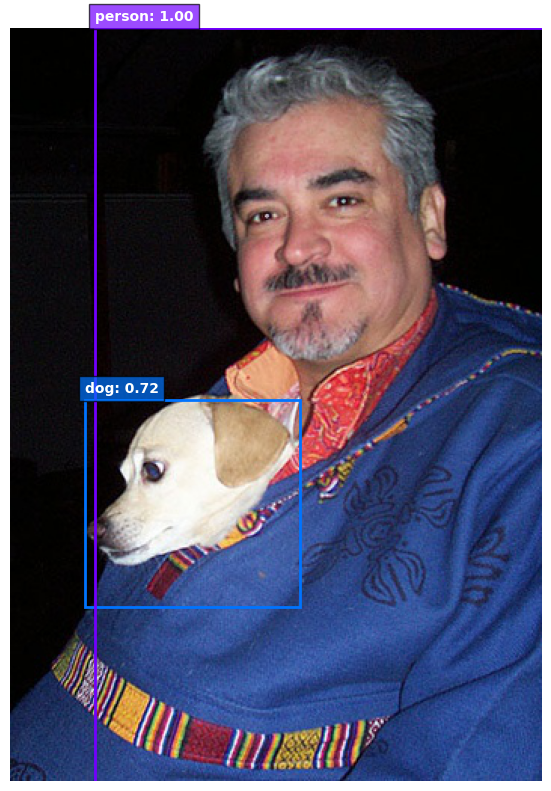

In [8]:
# Visualize detections
fig = visualize_detections(
    original_image, 
    detection_bboxes, 
    detection_classes, 
    detection_probs, 
    scale
)
plt.show()

## 6. Compare Different Confidence Thresholds

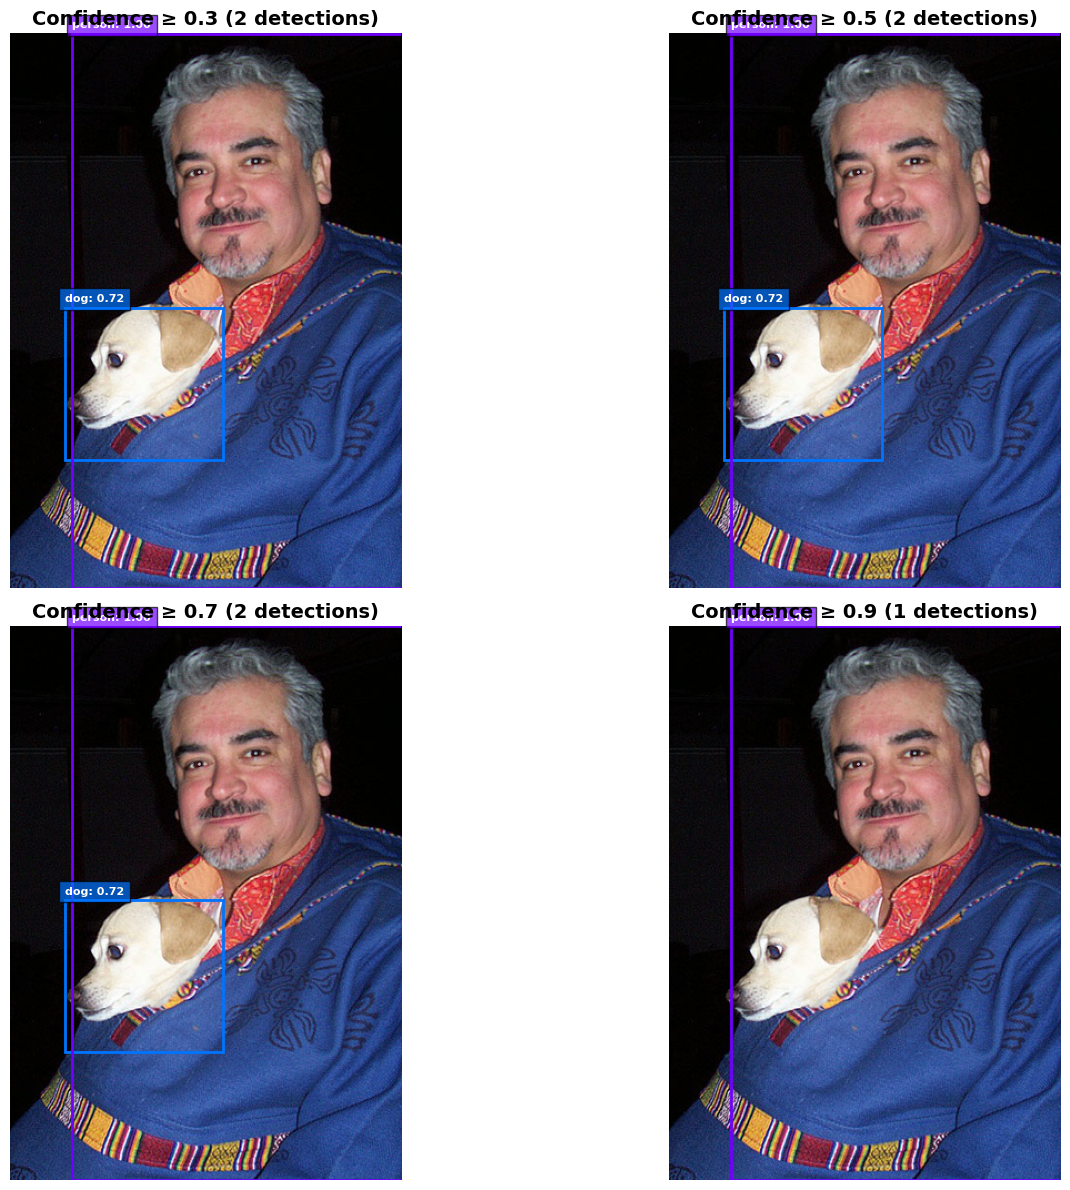

In [9]:
# Compare different confidence thresholds
thresholds = [0.3, 0.5, 0.7, 0.9]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, threshold in enumerate(thresholds):
    # Run inference with different thresholds
    bboxes, classes, probs = run_inference(model, image_tensor, threshold)
    
    # Display on subplot
    ax = axes[idx]
    ax.imshow(original_image)
    ax.set_title(f'Confidence ≥ {threshold} ({len(bboxes)} detections)', fontsize=14, weight='bold')
    ax.axis('off')
    
    # Draw bounding boxes
    colors = plt.cm.hsv(np.linspace(0, 1, len(VOC_CLASSES)))
    
    for bbox, cls, prob in zip(bboxes, classes, probs):
        x1, y1, x2, y2 = bbox / scale
        width = x2 - x1
        height = y2 - y1
        
        class_idx = cls.item()
        color = colors[class_idx]
        
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
        label = f'{VOC_CLASSES[class_idx]}: {prob:.2f}'
        ax.text(
            x1, y1 - 5, label,
            bbox=dict(facecolor=color, alpha=0.7),
            fontsize=8, color='white', weight='bold'
        )

plt.tight_layout()
plt.show()

## 7. Analyze Detections by Class

/tmp/.khin/ipykernel_3810505/3406137668.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(confidence_data, labels=classes_list, patch_artist=True)


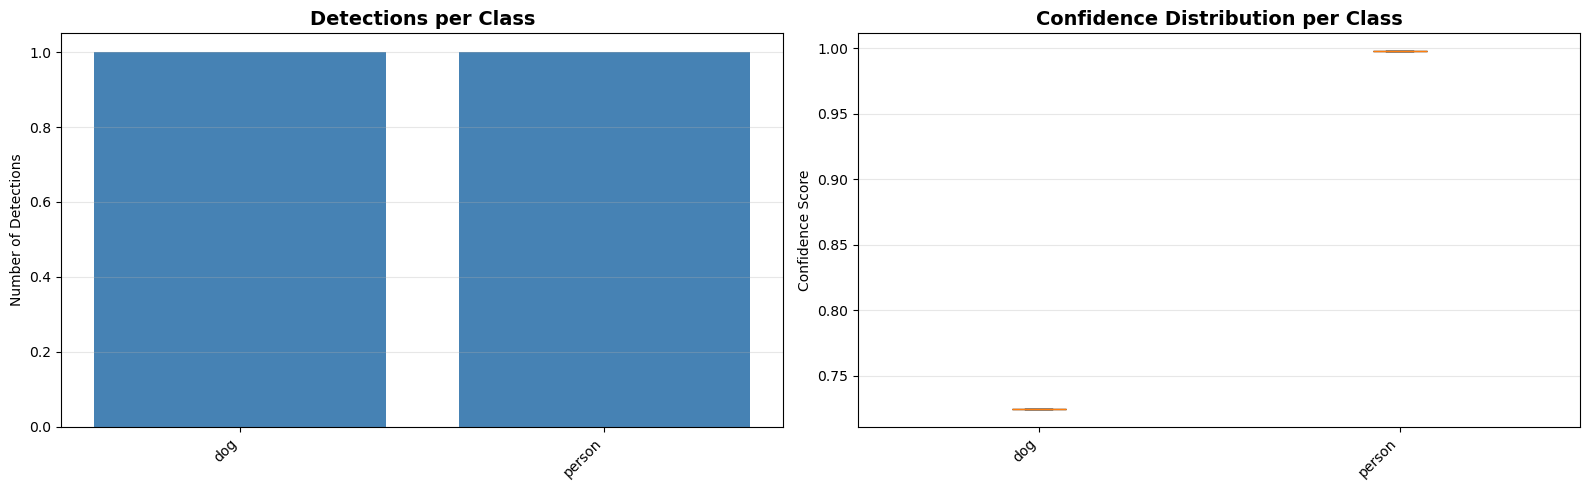


Detection Summary:
--------------------------------------------------
dog            :  1 objects (avg confidence: 0.725)
person         :  1 objects (avg confidence: 0.998)


In [10]:
# Analyze detections
bboxes, classes, probs = run_inference(model, image_tensor, 0.5)

# Count detections per class
class_counts = {}
class_confidences = {}

for cls, prob in zip(classes, probs):
    class_name = VOC_CLASSES[cls.item()]
    if class_name not in class_counts:
        class_counts[class_name] = 0
        class_confidences[class_name] = []
    class_counts[class_name] += 1
    class_confidences[class_name].append(prob.item())

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart of detections per class
if class_counts:
    classes_list = list(class_counts.keys())
    counts_list = list(class_counts.values())
    
    ax1.bar(range(len(classes_list)), counts_list, color='steelblue')
    ax1.set_xticks(range(len(classes_list)))
    ax1.set_xticklabels(classes_list, rotation=45, ha='right')
    ax1.set_ylabel('Number of Detections')
    ax1.set_title('Detections per Class', fontsize=14, weight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Box plot of confidence scores
    confidence_data = [class_confidences[c] for c in classes_list]
    bp = ax2.boxplot(confidence_data, labels=classes_list, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    ax2.set_xticklabels(classes_list, rotation=45, ha='right')
    ax2.set_ylabel('Confidence Score')
    ax2.set_title('Confidence Distribution per Class', fontsize=14, weight='bold')
    ax2.grid(axis='y', alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No detections found', ha='center', va='center', fontsize=14)
    ax2.text(0.5, 0.5, 'No detections found', ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.show()

# Print summary
print("\nDetection Summary:")
print("-" * 50)
for class_name, count in class_counts.items():
    avg_conf = np.mean(class_confidences[class_name])
    print(f"{class_name:15s}: {count:2d} objects (avg confidence: {avg_conf:.3f})")

## 8. Batch Processing Multiple Images

Process multiple images from the dataset to showcase the bounding box detection mechanism across various scenarios.

In [11]:
import glob

# Get multiple test images
image_dir = 'modernized_fpn/data/VOCdevkit/VOC2007/JPEGImages/'
image_files = glob.glob(os.path.join(image_dir, '*.jpg'))[:6]  # Process first 6 images

# Create grid visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, image_path in enumerate(image_files):
    # Process image
    image_tensor, original_image, scale = preprocess_image(image_path)
    bboxes, classes, probs = run_inference(model, image_tensor, 0.5)
    
    # Display
    ax = axes[idx]
    ax.imshow(original_image)
    ax.set_title(f'{os.path.basename(image_path)}\n{len(bboxes)} detections', fontsize=10)
    ax.axis('off')
    
    # Draw bounding boxes
    colors = plt.cm.hsv(np.linspace(0, 1, len(VOC_CLASSES)))
    
    for bbox, cls, prob in zip(bboxes, classes, probs):
        x1, y1, x2, y2 = bbox / scale
        width = x2 - x1
        height = y2 - y1
        
        class_idx = cls.item()
        color = colors[class_idx]
        
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
        label = f'{VOC_CLASSES[class_idx]}: {prob:.2f}'
        ax.text(
            x1, y1 - 3, label,
            bbox=dict(facecolor=color, alpha=0.7),
            fontsize=7, color='white', weight='bold'
        )

plt.tight_layout()
plt.show()

## 9. Save Detection Results

Save the visualization with bounding boxes to a file.

Saved detection result to: detection_result.jpg


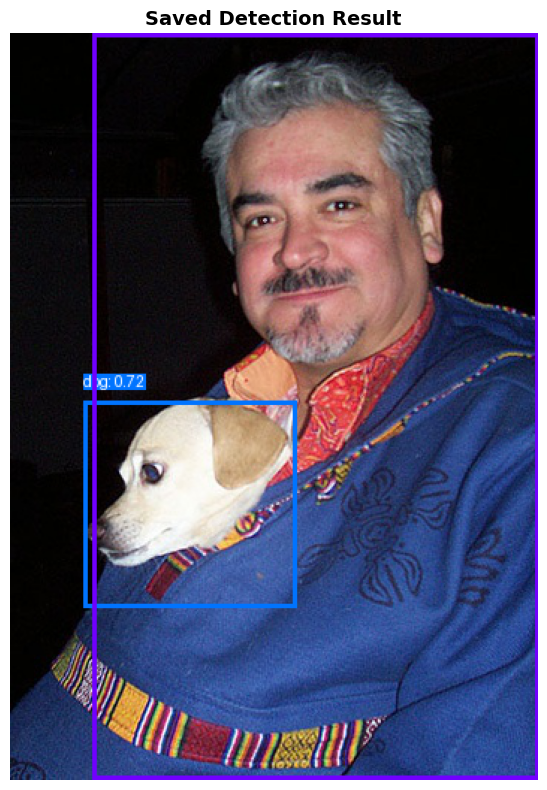

In [12]:
# Process and save a detection result
output_path = 'detection_result.jpg'

# Load and process image
image_tensor, original_image, scale = preprocess_image(IMAGE_PATH)
bboxes, classes, probs = run_inference(model, image_tensor, 0.5)

# Draw on PIL image
result_image = draw_detections_pil(
    original_image.copy(), 
    bboxes, 
    classes, 
    probs, 
    scale
)

# Save
result_image.save(output_path, quality=95)
print(f"Saved detection result to: {output_path}")

# Display
plt.figure(figsize=(12, 8))
plt.imshow(result_image)
plt.axis('off')
plt.title('Saved Detection Result', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()